# Convolutional Neural Network (CNN)
Convolutional Neural Networks (CNNs) are a specialized class of deep neural networks designed primarily for processing structured grid data, most notably images, but also applicable to time-series data, audio spectrograms, and other grid-like structures. Unlike traditional fully connected neural networks that treat each input pixel independently, CNNs leverage three key architectural principles: local connectivity, parameter sharing, and spatial pooling, which make them particularly effective for visual tasks.

The fundamental building block of a CNN is the convolutional layer, which applies filters (or kernels) that slide across the input image to detect local patterns such as edges, textures, and shapes. This local connectivity means each neuron in a convolutional layer is connected only to a small region of the previous layer's output, allowing the network to focus on local features while dramatically reducing the number of parameters compared to fully connected networks. Parameter sharing further enhances efficiency—the same filter weights are used across all spatial positions, enabling the network to detect features regardless of their location in the image.

CNNs typically follow convolutional layers with pooling layers (usually max-pooling or average-pooling), which downsample the feature maps by summarizing local regions. This pooling operation provides translational invariance (making the network robust to small shifts in input), reduces computational complexity, and helps prevent overfitting by progressively reducing spatial dimensions while retaining important features. The network architecture usually follows a pattern of alternating convolutional and pooling layers, gradually increasing the number of filters (to capture more complex patterns) while decreasing spatial dimensions, culminating in one or more fully connected layers for final classification or regression tasks.

What makes CNNs revolutionary is their hierarchical feature learning capability—early layers learn simple features like edges and corners, middle layers combine these into textures and patterns, and deeper layers assemble these into complex object parts and eventually complete objects. This biological inspiration, loosely mimicking the visual cortex's organization, has made CNNs the dominant architecture for computer vision tasks including image classification, object detection, semantic segmentation, and facial recognition. Modern CNN architectures like ResNet, Inception, and EfficientNet have achieved superhuman performance on benchmark datasets, demonstrating their remarkable ability to learn discriminative features directly from raw pixel data without extensive manual feature engineering.



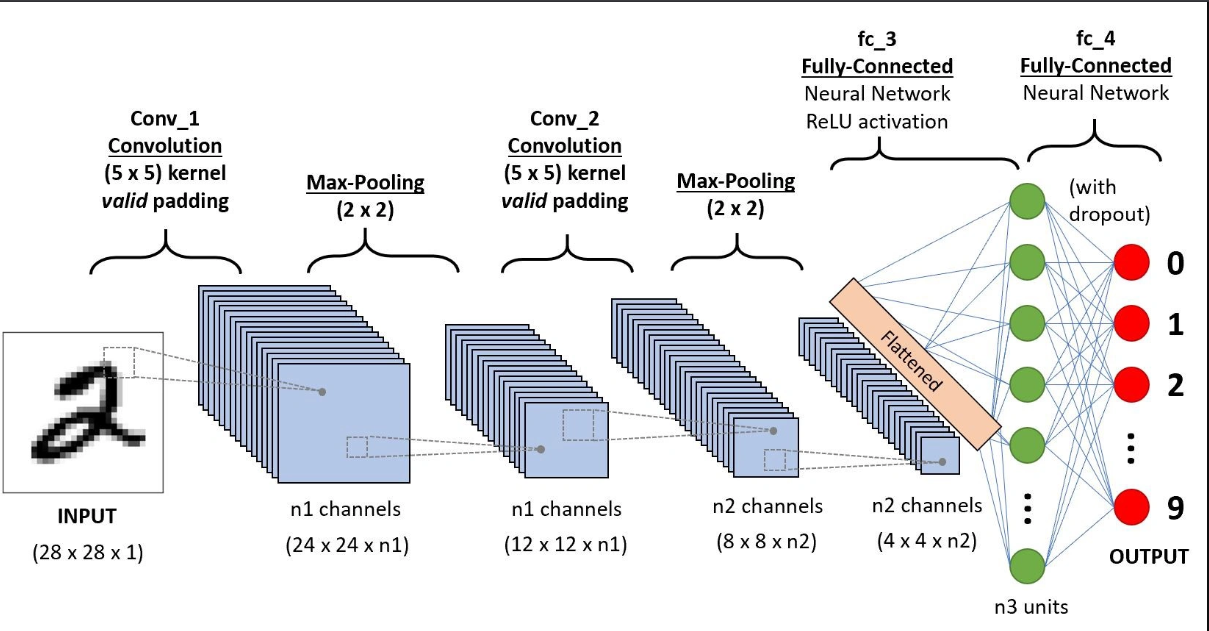

## Terms in CNN

- Convolution: Mathematical operation where a filter slides over input data, computing dot products to detect features. It preserves spatial relationships while extracting local patterns.

- Kernel/Filter: Small matrix (e.g., 3×3, 5×5) containing learnable weights that detects specific features like edges, textures, or patterns. Multiple filters enable detection of different features simultaneously.

- Feature Map: Output of applying a filter to input. Each filter produces one feature map showing where the detected feature appears in the input.

- Stride: How many pixels the filter moves each step. Larger strides (2,3) reduce spatial dimensions faster; stride 1 preserves more spatial information.

- Padding: Adding extra pixels (usually zeros) around input borders. "Same" padding preserves spatial dimensions; "Valid" padding uses no padding, reducing dimensions.



## Architectural Elements
- Pooling: Downsampling operation (Max or Average) that reduces spatial dimensions, controls overfitting, and provides translation invariance.

- Receptive Field: The region in input space affecting a particular neuron. Grows deeper in network, enabling detection of larger patterns.

- Channels/Depth: Number of filters in a layer. RGB images have 3 input channels; convolutional layers output multiple feature map channels.

- Activation Function: Non-linear functions (ReLU, sigmoid, tanh) applied after convolution to introduce non-linearity, enabling complex pattern learning.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [4]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
df = pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df = df.dropna().reset_index(drop=True)

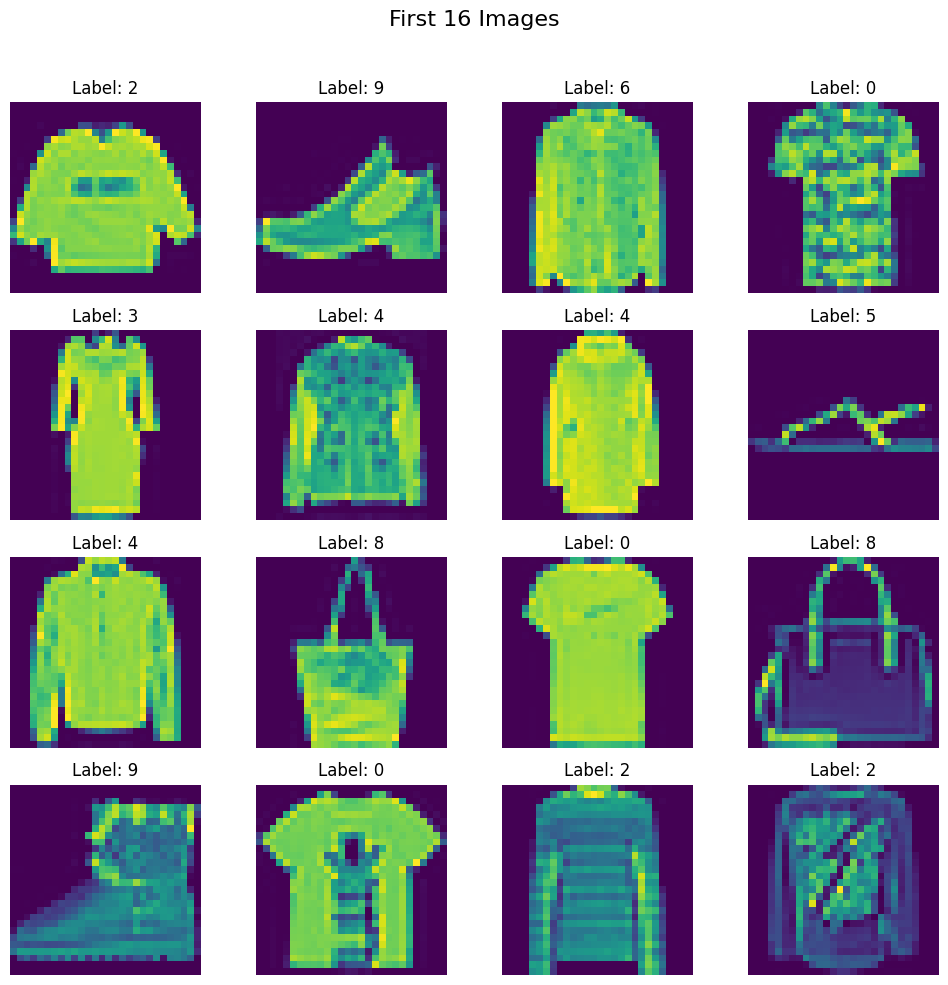

In [6]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

In [7]:
# train test split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train = X_train/255.0
X_test = X_test/255.0

In [10]:
class CustomDataset(Dataset):
    """
    Custom PyTorch Dataset class for handling image data.
    This dataset prepares data for both CNN and fully connected network architectures.
    """

    def __init__(self, features, labels):
        """
        Initialize the dataset with features and labels.

        Args:
            features: Input data (usually image data in numpy array format)
            labels: Corresponding labels/targets for the input data
        """

        # Convert to PyTorch tensors with appropriate data types
        # For CNN architecture:
        self.features = torch.tensor(features, dtype=torch.float32).reshape(-1, 1, 28, 28)
        # Explanation of reshape(-1, 1, 28, 28):
        # - -1: Automatically infers the batch size dimension
        #        (e.g., 60,000 for full MNIST training set)
        # - 1: Number of channels (1 for grayscale images like MNIST)
        #      3 for RGB color images
        # - 28, 28: Height and width of the image in pixels
        #
        # CNN expects input shape: (batch_size, channels, height, width)
        # This format is crucial because:
        # 1. Convolutional layers operate on spatial dimensions (height × width)
        # 2. They preserve spatial relationships between pixels
        # 3. Filters/kernels slide across height and width dimensions
        # 4. Multiple channels allow processing of different feature maps

        # For fully connected network (alternative approach):
        # self.features = torch.tensor(features, dtype=torch.float32).reshape(-1, 784)
        # Where 784 = 28 × 28 (flattened image)
        # This would be used with nn.Linear(784, ...) layers

        # Convert labels to long tensor (required for classification tasks)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: Number of samples
        """
        return len(self.features)

    def __getitem__(self, index):
        """
        Retrieves a single sample from the dataset at the specified index.

        Args:
            index (int): Index of the sample to retrieve

        Returns:
            tuple: (features_tensor, label_tensor) for the specified sample
        """
        return self.features[index], self.labels[index]

In [11]:
train_dataset = CustomDataset(X_train, y_train)

In [12]:
test_dataset = CustomDataset(X_test, y_test)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

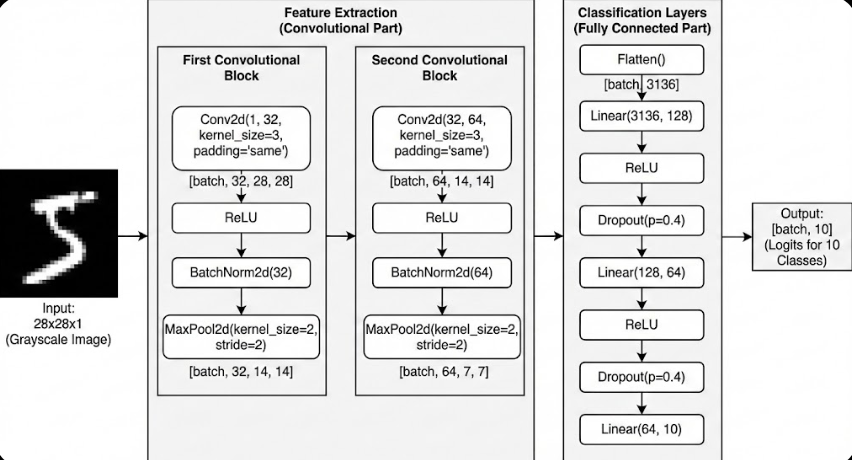

In [14]:
class MyNN(nn.Module):
    """
    Convolutional Neural Network (CNN) for image classification.
    Designed for MNIST dataset (28×28 grayscale images, 10 classes).
    """

    def __init__(self, input_features):
        """
        Initialize the CNN architecture.

        Args:
            input_features (int): Number of input channels.
                                  For MNIST: 1 (grayscale)
                                  For RGB images: 3
        """
        super().__init__()  # Initialize parent nn.Module class

        # ============================================
        # FEATURE EXTRACTION LAYERS (Convolutional Part)
        # ============================================
        self.features = nn.Sequential(
            # -------------------------------------------------
            # First Convolutional Block
            # -------------------------------------------------
            nn.Conv2d(input_features, 32, kernel_size=3, padding='same'),
            # Input:  [batch, input_features, 28, 28]
            # Output: [batch, 32, 28, 28]
            # - kernel_size=3: 3×3 convolutional filter
            # - padding='same': Output size equals input size (28×28)
            # - 32 filters: Creates 32 feature maps

            nn.ReLU(),
            # ReLU activation: f(x) = max(0, x)
            # Introduces non-linearity, allowing network to learn complex patterns

            nn.BatchNorm2d(32),
            # Batch Normalization for 32 channels
            # Normalizes activations: stabilizes training, speeds convergence

            nn.MaxPool2d(kernel_size=2, stride=2),
            # Max Pooling: Downsampling operation
            # Input:  [batch, 32, 28, 28]
            # Output: [batch, 32, 14, 14]
            # - kernel_size=2: 2×2 pooling window
            # - stride=2: Move 2 pixels each step
            # Reduces spatial dimensions by half, increases receptive field

            # -------------------------------------------------
            # Second Convolutional Block
            # -------------------------------------------------
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            # Input:  [batch, 32, 14, 14]
            # Output: [batch, 64, 14, 14]
            # Increases depth (channels) to capture more complex features

            nn.ReLU(),
            # Another non-linear activation

            nn.BatchNorm2d(64),
            # Batch Normalization for 64 channels

            nn.MaxPool2d(kernel_size=2, stride=2)
            # Input:  [batch, 64, 14, 14]
            # Output: [batch, 64, 7, 7]
            # Final spatial dimensions: 7×7
        )

        # ============================================
        # CLASSIFICATION LAYERS (Fully Connected Part)
        # ============================================
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Input:  [batch, 64, 7, 7]
            # Output: [batch, 64*7*7 = 3136]
            # Flattens 3D feature maps into 1D vector for dense layers

            nn.Linear(64*7*7, 128),
            # Fully connected layer: 3136 → 128 neurons
            # Learns global patterns from extracted features

            nn.ReLU(),
            # Non-linear activation

            nn.Dropout(p=0.4),
            # Dropout regularization: Randomly sets 40% of neurons to zero
            # Prevents overfitting, encourages robust feature learning

            nn.Linear(128, 64),
            # Another fully connected layer: 128 → 64 neurons
            # Further refines feature representation

            nn.ReLU(),
            # Non-linear activation

            nn.Dropout(p=0.4),
            # Another dropout layer for regularization

            nn.Linear(64, 10)
            # Output layer: 64 → 10 neurons (for 10 MNIST digit classes)
            # No activation function here (will be used with CrossEntropyLoss)
        )

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape [batch, channels, height, width]

        Returns:
            torch.Tensor: Output logits of shape [batch, 10]
        """
        # Feature extraction: Convolutional layers
        x = self.features(x)
        # Input:  [batch, 1, 28, 28] (for MNIST)
        # Output: [batch, 64, 7, 7]

        # Classification: Fully connected layers
        x = self.classifier(x)
        # Output: [batch, 10] (logits for 10 classes)

        return x

In [17]:
learning_rate = 0.01
epochs = 100

In [18]:
model = MyNN(1)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [19]:
# Training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # Move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # Forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 0.6459098496933778
Epoch: 2 , Loss: 0.3866609168301026
Epoch: 3 , Loss: 0.3268849913924933
Epoch: 4 , Loss: 0.29059686361749965
Epoch: 5 , Loss: 0.26509579138457773
Epoch: 6 , Loss: 0.24468714511642853
Epoch: 7 , Loss: 0.23187719891220332
Epoch: 8 , Loss: 0.21382498350242773
Epoch: 9 , Loss: 0.20282341962556044
Epoch: 10 , Loss: 0.19065202671227355
Epoch: 11 , Loss: 0.1767118217088282
Epoch: 12 , Loss: 0.16663642418632904
Epoch: 13 , Loss: 0.1588246565045168
Epoch: 14 , Loss: 0.14869449350377545
Epoch: 15 , Loss: 0.14293338707710307
Epoch: 16 , Loss: 0.13353965645159285
Epoch: 17 , Loss: 0.12879327533083657
Epoch: 18 , Loss: 0.12082548032701015
Epoch: 19 , Loss: 0.11187005537531028
Epoch: 20 , Loss: 0.10821504837654841
Epoch: 21 , Loss: 0.10374100268639934
Epoch: 22 , Loss: 0.0983685591055546
Epoch: 23 , Loss: 0.09397087138099595
Epoch: 24 , Loss: 0.08718490662580977
Epoch: 25 , Loss: 0.08320883661881089
Epoch: 26 , Loss: 0.08225964157675238
Epoch: 27 , Loss: 0.0794446

In [20]:
model.eval()
# Evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # Move data to GPU
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)


0.9269166666666667
